In [1]:
import os
import shutil

import pandas as pd

## Setup directories

In [2]:
MAIN_DIR = "."
DATA_DIR = os.path.join(MAIN_DIR, "data")

# Where we will store data from all sources after combining it
ALL_DATA_DIR = os.path.join(DATA_DIR, "combined")
# This will hold the converted versions of the PDF documents
SPLIT_TEXT_FILES_DIR = os.path.join(ALL_DATA_DIR, "text_files_split")
# This will hold everything related to translating text, including the results of the translations
TRANSLATIONS_DIR = os.path.join(ALL_DATA_DIR, "translations")

TRANSLATIONS_TEXT_DIR = os.path.join(TRANSLATIONS_DIR, "texts")

OUTPUT_DIR = os.path.join(ALL_DATA_DIR, "output")
if os.path.exists(OUTPUT_DIR):
    shutil.rmtree(OUTPUT_DIR)
os.makedirs(OUTPUT_DIR)

## Paragraph delimiter

This is the string which divides paragraphs in our texts

In [3]:
paragraph_delimiter = "\n\n" + "=" * 20 + "\n\n"

## Read in metadata

In [4]:
df_speeches = pd.read_csv(os.path.join(ALL_DATA_DIR, "document_data.csv"), index_col="id")
df_speeches.Date = pd.to_datetime(df_speeches["Date"])
df_speeches.head(1)

,Title,Type,Date,Source,link,scanned
id,,,,,,
0,Accountability for Perpetrators: UN Officials ...,Official Statement,2019-11-07,UN Special Representative of the Secretary-Gen...,https://www.globalr2p.org/wp-content/uploads/2...,False


## Clean unwanted files

In [5]:
# Load pre-filled list with unwanted documents
keep = pd.read_csv(os.path.join(DATA_DIR, "drop_it_like_its_hot.csv"), index_col="id")
df_speeches = df_speeches.join(keep)

# For some years, we only want speeches from some dates
keep_dates = {
    2014: ["2014-09-08"],
    2015: ["2015-09-08"],
    2016: ["2016-09-06", "2016-09-07"],
    2017: ["2017-09-06", "2017-09-07"],
}
for year, dates in keep_dates.items():
    df_speeches.loc[(df_speeches["Date"].dt.year == year) & ~df_speeches["Date"].isin(dates), "to_keep"] = False
    

# For 2018, 2019, we do not want speeches scraped from GR2P. We can recognize them from their non-null "link"
df_speeches.loc[df_speeches["Date"].dt.year.isin([2018, 2019]) & ~df_speeches["link"].isna(), "to_keep"] = False

# Correction: wrong date
df_speeches.loc[135, "Date"] = pd.Timestamp(2017, 9, 6)

# Other documents with various problems which we do not want included
bad_ids = [
    532, # (weird encoding)
    534, # (cannot be rec by LD)
    479, # (tilted?)
    470, # (just bad)
    518, # (Turkish, not scanned but broken)
]

df_speeches.loc[bad_ids, "to_keep"] = False

### Record the IDs we have left

In [6]:
ids_to_keep = df_speeches[df_speeches["to_keep"]].index

## Read in paragraphs

In [7]:
par_list = []
for i, filename in enumerate(os.listdir(TRANSLATIONS_TEXT_DIR)):
    with open(os.path.join(TRANSLATIONS_TEXT_DIR, filename), "r") as fp:
        text = fp.read()

    paragraphs = list(text.split(paragraph_delimiter))
    for j, paragraph in enumerate(paragraphs):
        par_list.append({
            "id": int(filename.split(".")[0]),
            "paragraph": j,
            "text": paragraph
        })
df_paragraphs = pd.DataFrame(par_list).sort_values(by=["id", "paragraph"])

df_paragraphs["n_chars"] = df_paragraphs.text.str.len()
df_paragraphs["n_tokens"] = df_paragraphs.text.str.split().apply(len)

### Filter paragraphs

Only leave the ones from documents we care about

In [8]:
df_paragraphs = df_paragraphs[df_paragraphs["id"].isin(ids_to_keep)]

## Clean text

In [9]:
df_paragraphs["clean"] = df_paragraphs.text.str.replace(r"\n+\t*\s*\n", "\n")
df_paragraphs["clean"] = df_paragraphs["clean"].str.replace("[^\w]|[0-9]", " ").str.replace(
    "\s+", " "
).str.lower().str.strip()

df_paragraphs["n_chars_clean"] = df_paragraphs.clean.str.len()
df_paragraphs["n_tokens_clean"] = df_paragraphs.clean.str.split().apply(len)

### Join small paragraphs

Merge every paragraph which is under X token with the next one

In [10]:
%%time
min_paragraph_tokens = 100

for doc_id in set(df_paragraphs["id"]):
    docs = df_paragraphs[df_paragraphs["id"] == doc_id].sort_values(by="paragraph")
    
    # Attach an ID to each paragraph, later join all paragraphs with the same ID
    joined_id = 0
    # Keep the number of tokens in the current joined chunk
    run_tokens = 0
    
    # How many paragraphs in this doc
    n_paragraphs = len(docs)
    
    for par_id, n_tokens in enumerate(docs["n_tokens_clean"]):
        # If the last paragraph is small, join it with the previous one
        if par_id == n_paragraphs - 1:
            if n_tokens < min_paragraph_tokens and joined_id > 0:
                joined_id -= 1
        
        df_paragraphs.loc[
            (df_paragraphs["id"] == doc_id) & (df_paragraphs["paragraph"] == par_id), "joined_id"
        ] = int(joined_id)
        
        run_tokens += n_tokens
        # If the resulting paragraph is bigger than the minimal tokens, move on to joining a new one
        if run_tokens >= min_paragraph_tokens:
            joined_id += 1
            run_tokens = 0

CPU times: user 11.3 s, sys: 10.3 ms, total: 11.4 s
Wall time: 11.3 s


In [11]:
df_joined = df_paragraphs.groupby(["id", "joined_id"])[["text"]].sum().reset_index()
df_joined["text"] = df_joined["text"].str.replace(r"\n+\t*\s*\n", "\n")
df_joined["n_tokens"] = df_joined.text.str.split().apply(len)
df_joined["n_chars"] = df_joined.text.str.len()

df_joined.rename(columns={"joined_id": "paragraph"}, inplace=True)

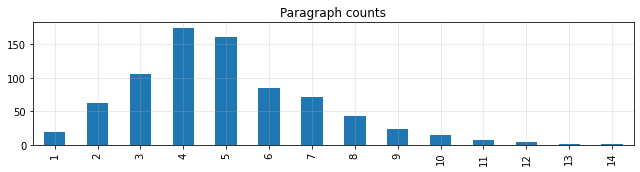

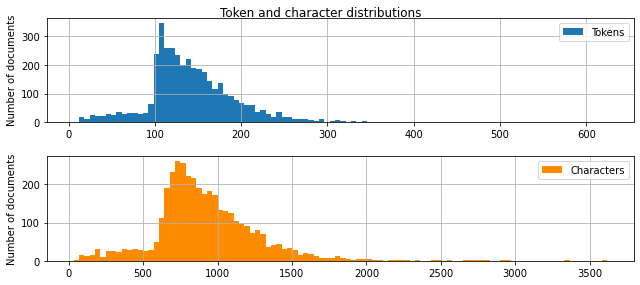

In [12]:
import matplotlib.pyplot as plt

par_counts = df_joined.groupby("id")["paragraph"].count()

%matplotlib inline
par_counts.value_counts().sort_index().plot.bar(figsize=(9,2.5))
plt.grid(alpha=0.3)
plt.title("Paragraph counts")
plt.tight_layout()

fig, axs = plt.subplots(2,1, figsize=(9, 4))

df_joined["n_tokens"].hist(bins=100, ax=axs[0], label="Tokens")
df_joined["n_chars"].hist(bins=100, ax=axs[1], color="darkorange", label="Characters")

for ax in axs:
    ax.legend()
    ax.set_ylabel("Number of documents")
plt.suptitle("Token and character distributions")
plt.tight_layout()

## Join paragraphs

In [13]:
out_separator = ".\n\n"

In [15]:
final_texts = df_joined.groupby("id")["text"].apply(lambda paragraphs: out_separator.join(paragraphs).strip())

final_speeches = df_speeches[df_speeches["to_keep"]]

final_speeches.loc[:, "text"] = final_texts
final_speeches = final_speeches[~final_speeches["text"].isna()]

## Merge texts

In [16]:
final_docs = final_speeches.groupby([final_speeches.Date.dt.year, final_speeches.Source])["text"].apply(
    lambda texts: out_separator.join([t for t in texts if not pd.isna(t)])
)

## Save texts

In [17]:
for (year, actor), text in final_docs.iteritems():
    year_dir = os.path.join(OUTPUT_DIR, str(year))
    out_file = os.path.join(year_dir, f"{actor}.txt")
    if not os.path.exists(year_dir):
        os.makedirs(year_dir)
    
    with open(out_file, "w") as fp:
        fp.write(text)